In [1]:
!python -m venv myenv
!source myenv/bin/activate

In [9]:
import pandas as pd
import os
import re
import spacy

import nltk
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from spellchecker import SpellChecker

#Load SpaCy model
spacy = spacy.load('en_core_web_sm')

# Download NLTK stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print(os.listdir())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
['.DS_Store', 'CSCI 183 Project-Preprocessing.ipynb', 'ball_by_ball_data_commentary.csv', '.env', '.ipynb_checkpoints', 'myenv', 'Project - Analysis.ipynb', 'spell_checked_df.csv']


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pragnyavijayan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pragnyavijayan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pragnyavijayan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pragnyavijayan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
df = pd.read_csv('ball_by_ball_data_commentary.csv')
df

,match_no,batting_team,batting_side,overs,runs,"bowler_to_batsman, runs",commentary
0,1,AFG,2,0.1,1,"Madushanka to Hazratullah Zazai, 1 run",nudged down to fine leg for a single
1,1,AFG,2,0.2,0,"Madushanka to Rahmanullah, no run","lovely delivery, Holds its line and beats the ..."
2,1,AFG,2,0.3,1lb,"Madushanka to Rahmanullah, 1 leg bye",shaping back into him. He squeezes it thbrough...
3,1,AFG,2,0.4,0,"Madushanka to Hazratullah Zazai, no run","driven to extra cover, where it's well fielded"
4,1,AFG,2,0.5,5w,"Madushanka to Hazratullah Zazai, 5 wide","well, that's help. 5 free runs gifted to Afgha..."
...,...,...,...,...,...,...,...
2646,13,SL,1,19.2,2,"Naseem Shah to Rajapaksa, 2 runs",gets back on strike with some hard running. Sl...
2647,13,SL,1,19.3,2,"Naseem Shah to Rajapaksa, 2 runs",another double. And 160 is breached. Full ball...
2648,13,SL,1,19.4,0,"Naseem Shah to Rajapaksa, no run","short ball, slower ball on middle. Rajapaksa w..."
2649,13,SL,1,19.5,4,"Naseem Shah to Rajapaksa, FOUR runs",cute shot! Full on middle and leg. Rajapaksa m...


In [11]:
df.columns

Index(['match_no', 'batting_team', 'batting_side', 'overs', 'runs',
       'bowler_to_batsman, runs', 'commentary'],
      dtype='object')

In [12]:
df['commentary']

0                    nudged down to fine leg for a single
1       lovely delivery, Holds its line and beats the ...
2       shaping back into him. He squeezes it thbrough...
3          driven to extra cover, where it's well fielded
4       well, that's help. 5 free runs gifted to Afgha...
                              ...                        
2646    gets back on strike with some hard running. Sl...
2647    another double. And 160 is breached. Full ball...
2648    short ball, slower ball on middle. Rajapaksa w...
2649    cute shot! Full on middle and leg. Rajapaksa m...
2650    momentum with Sri Lanka! And the tournament's ...
Name: commentary, Length: 2651, dtype: object

In [13]:
print(df.isnull().sum())

match_no                   0
batting_team               0
batting_side               0
overs                      0
runs                       0
bowler_to_batsman, runs    3
commentary                 3
dtype: int64


In [14]:
df.dropna(subset=['bowler_to_batsman, runs', 'commentary'], inplace=True)

print(df.isnull().sum())

match_no                   0
batting_team               0
batting_side               0
overs                      0
runs                       0
bowler_to_batsman, runs    0
commentary                 0
dtype: int64


In [15]:
df["runs"].value_counts()

1      1002
0       781
4       249
2       191
W       147
6       127
1w       74
1lb      33
3         9
5w        8
1nb       6
2w        3
5nb       3
4lb       3
1b        3
2lb       2
3nb       2
4b        2
3w        1
2b        1
2nb       1
Name: runs, dtype: int64

<Axes: ylabel='runs'>

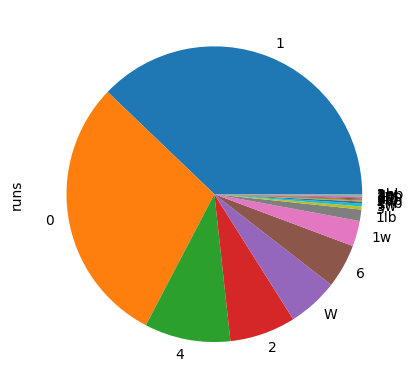

In [16]:
df["runs"].value_counts(dropna=False).plot(kind="pie")

W      147
1w      74
1lb     33
5w       8
1nb      6
2w       3
5nb      3
4lb      3
1b       3
2lb      2
3nb      2
4b       2
3w       1
2b       1
2nb      1
Name: runs, dtype: int64


<Axes: ylabel='runs'>

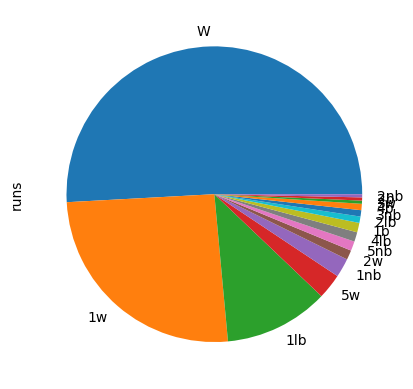

In [17]:
new_df = df[~df['runs'].str.isnumeric()]
print(new_df['runs'].value_counts())
new_df['runs'].value_counts(dropna=False).plot(kind="pie")

In [18]:
def separate_special_tags_on_runs(text):
    match = re.match(r'(\d+)', text)
    if match:
        return int(match.group(1))
    elif text == 'W':
        return 0
    else:
        return None

<Axes: ylabel='numerical_runs'>

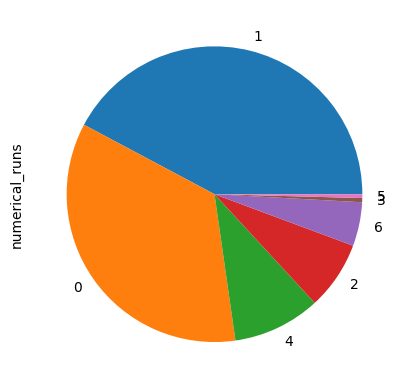

In [19]:
df['numerical_runs'] = df['runs'].apply(lambda x: separate_special_tags_on_runs(x))
df["numerical_runs"].value_counts(dropna=False).plot(kind="pie")

In [20]:
bowler_strings = []
batsman_strings = []

# Bowler
for x in df['bowler_to_batsman, runs']:
    match = re.search(r'^(.*?)\s+to', x)
    if match:
        bowler_strings.append(match.group(1).strip())

df['bowler'] = bowler_strings

# Batsman
for y in df['bowler_to_batsman, runs']:
    match = re.search(r'to\s(.*?),', y)
    if match:
        batsman_strings.append(match.group(1).strip())
        
df['batsman'] = batsman_strings

In [21]:
df

,match_no,batting_team,batting_side,overs,runs,"bowler_to_batsman, runs",commentary,numerical_runs,bowler,batsman
0,1,AFG,2,0.1,1,"Madushanka to Hazratullah Zazai, 1 run",nudged down to fine leg for a single,1,Madushanka,Hazratullah Zazai
1,1,AFG,2,0.2,0,"Madushanka to Rahmanullah, no run","lovely delivery, Holds its line and beats the ...",0,Madushanka,Rahmanullah
2,1,AFG,2,0.3,1lb,"Madushanka to Rahmanullah, 1 leg bye",shaping back into him. He squeezes it thbrough...,1,Madushanka,Rahmanullah
3,1,AFG,2,0.4,0,"Madushanka to Hazratullah Zazai, no run","driven to extra cover, where it's well fielded",0,Madushanka,Hazratullah Zazai
4,1,AFG,2,0.5,5w,"Madushanka to Hazratullah Zazai, 5 wide","well, that's help. 5 free runs gifted to Afgha...",5,Madushanka,Hazratullah Zazai
...,...,...,...,...,...,...,...,...,...,...
2646,13,SL,1,19.2,2,"Naseem Shah to Rajapaksa, 2 runs",gets back on strike with some hard running. Sl...,2,Naseem Shah,Rajapaksa
2647,13,SL,1,19.3,2,"Naseem Shah to Rajapaksa, 2 runs",another double. And 160 is breached. Full ball...,2,Naseem Shah,Rajapaksa
2648,13,SL,1,19.4,0,"Naseem Shah to Rajapaksa, no run","short ball, slower ball on middle. Rajapaksa w...",0,Naseem Shah,Rajapaksa
2649,13,SL,1,19.5,4,"Naseem Shah to Rajapaksa, FOUR runs",cute shot! Full on middle and leg. Rajapaksa m...,4,Naseem Shah,Rajapaksa


In [22]:
df['commentary'][4]

"well, that's help. 5 free runs gifted to Afghamistan, as this is so far down leg the keeper can do nought about it"

In [23]:
def named_entity_recognition (text):
    categories = ['PERSON', 'GPE']
    words = []
    
    doc = spacy(text)
    
    for word_and_ent in doc:
        if not word_and_ent.ent_type_ in categories:
            words.append(word_and_ent.text)
            
    cleaned_words = " ".join(words)
    
    return cleaned_words
    

In [25]:
def numero(text):
    return re.sub(r'\b\d+\b', '', text)

In [26]:
def correct_spelling(text):
    spell = SpellChecker()

    words = text.split()
    corrected_words = [spell.correction(word) if spell.correction(word) is not None else word for word in words]
    return ' '.join(corrected_words)

In [27]:
def replaced (text):
    words = ['single', 'double', 'couple', 'four', 'six', 'one', 'two', 'three', 'second', 'five', '50', '100', '150', 'fifty', 'hundred']
    for word in words:
        text = text.replace(word, '')
    return text

In [28]:
def stemming (text):
    porter = PorterStemmer()
    stemmed_words = []
    
    words = word_tokenize(text)
    for word in words: 
        stemmed_words.append(porter.stem(word))               
                
    stemmed_words = " ".join(stemmed_words)
    
    return stemmed_words

In [29]:
def lemmatization (text):
    lemmatizer = WordNetLemmatizer()

    lemmatized_words = []

    words = word_tokenize(text)
    for word in words: 
        lemmatized_words.append(lemmatizer.lemmatize(word))

    lemmatized_words = " ".join(lemmatized_words)

    return lemmatized_words

In [30]:
def remove_stopwords (text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    
    filtered_sentence = [word for word in word_tokens if word not in stop_words]
    
    return filtered_sentence

In [32]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

In [33]:
def preprocessing (text):
    text = text.lower()
    text = remove_punctuation(text)
    text = numero(text)
    text = correct_spelling(text)
    text = named_entity_recognition(text)
    text = replaced(text)
    text = stemming(text)
    text = lemmatization(text)
    text = remove_stopwords(text)
    
    return text

In [34]:
df['preprocessed_commentary'] = df['commentary'].apply(lambda x: preprocessing(x))
df.head()


KeyboardInterrupt



In [ ]:
#Saving it because spell_check takes a long time
df.to_csv("spell_checked_df", index=False, encoding='utf-8')

In [ ]:
df = pd.read_csv("spell_checked_df")
df

In [ ]:
def remove_words(commentary):
    words_to_remove = ["sri", "lanka", "west", "indies"]
    for word in words_to_remove:
        commentary = commentary.replace(word, "")
    return commentary

In [ ]:
df["preprocessed_commentary"] = df["preprocessed_commentary"].apply(remove_words)